# Group: CopyPaste
#### Dataset used: Dataset_Hospital_Vists.csv, test.csv
#### Participants: Ligia, Gina, Raza

#### Next step: add yes/no no show split to the age distribution and then carry on with EDA.

### Contents Draft

1. Problem and Goal Definition
2. Data Understanding

        2.1 Dataset Description
        2.2 Quick Analysis from Kaggle
3. Data Quality Check
4. Exploratory Data Analysis

        4.1 Target Variable Distribution 
        4.2 Relationships between variables
5. Data Cleaning and Preprocessing

        5.1 Updating Existing Features (note: see if we can extrapolate age of same patient from different row)
        5.2 Adding new features
6. Train-Test Split
7. Model Selection
8. Model Training
9. Model Evaluation
10. Model Interpretation
11. Fine-Tuning and Optimization

### 1. Problem and Goal Definition
Problem: Patients in a hospital miss their scheduled appointments.

Goal: Develop a machine learning model that predicts if a patient will miss a future appointment.

### 2. Data Understanding
#### 2.1 Dataset Description

- The dataset is at appointment level granularity and contains detail of each appointment and patient.

- It has 14 columns of which 1 will be our target variable: No-show.

- We mostly have information about an appointment's date and place and the patients' health details. A column also shows if a patient received an SMS before the appointment.

#### 2.2 Quick Analysis from Kaggle

- There is missing data in the columns Age, Community, Social Welfare, and some diseases.
- Female to Male ratio is 65:35.
- We have no NULLs in the target variable.

### 3. Data Quality Check

- Uniqueness
- Missing data
- Data Type Consistency

In [3]:
# Setting up environment with packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Importing the dataset

df = pd.read_csv("/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/Dataset_Hospital_Visits.csv")
df.head()

# Increase seaborn default resolution
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(5,6)})

# Give variables to color numbers

green = '#008000'
red = '#ff0000'


In [5]:
## Uniqueness

# Is each row unique?

print("Duplicate rows: " + str(df.duplicated().sum()))

# Is each appointmentID unique?

print("Duplicate appointments: " + str(df['AppointmentID'].duplicated().sum()))

Duplicate rows: 0
Duplicate appointments: 0


We can conclude that the dataset only containts unique IDs and no duplicates.

In [6]:
## Missing Data

# Which columns have missing data?

missing_data = df.isnull().sum()
total_entries = len(df)
percentage_missing = round((missing_data / total_entries) * 100, 2)

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                 Missing Count  Percentage Missing
PatientId                    0                0.00
AppointmentID                0                0.00
Sex                          0                0.00
ScheduledDate                0                0.00
AppointmentDate              0                0.00
Age                       8807                9.96
Community                10713               12.12
SocialWelfare            12519               14.16
Hipertension              8021                9.07
Diabetes                     0                0.00
Alcoholism               14889               16.84
Handcap                      0                0.00
SMS_received                 0                0.00
No-show                      0                0.00


As seen from Kaggle, Age, Community, SocialWelfare, Hipertension, and Alcoholism have significant null values.

In [7]:
## Data Type Consistency

df.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

1. PatientId and Age are to be converted to int from float as IDs must be int/str and ages are usually considered in whole number terms.
2. ScheduledDate and AppointmentDate must be timestamps and not objects.

### 4. Exploratory Data Analysis

- Distribution of the target variable.
- Distribution of age. Which age groups account for the most missing appointments?
- Do males or females miss more appointments?
- How does the time affect the outcome?
- Is appointment date > scheduled data?

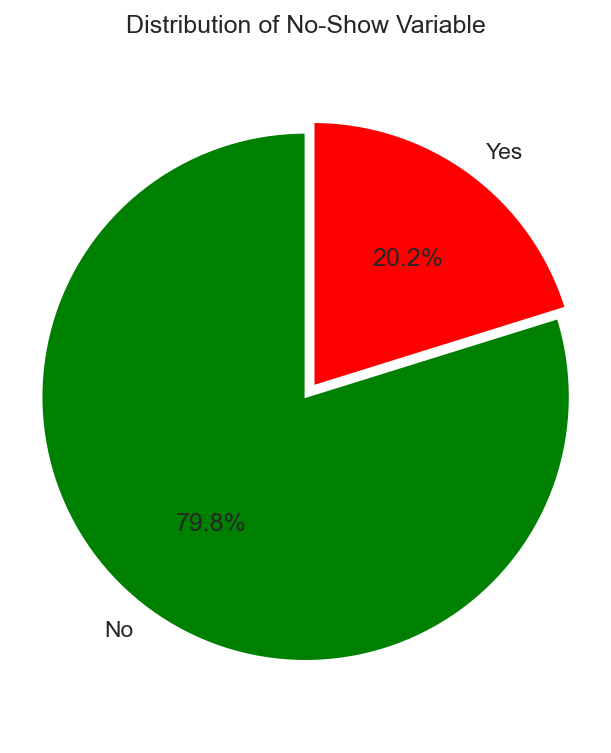

In [17]:
## Distribution of the target variable

value_counts = df['No-show'].value_counts()

labels = value_counts.index
sizes = value_counts.values

colors = [green,red]  # Customize colors
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

plt.title('Distribution of No-Show Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.show()

1 in 5 appointments are missed on average.

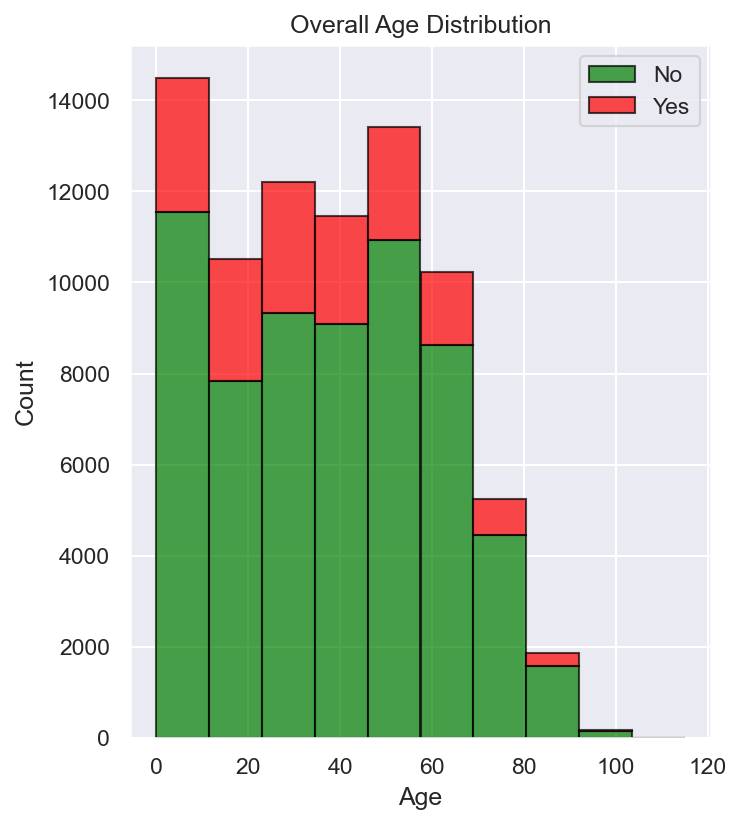

In [23]:
# Which age group misses more appointments?

# Plot histogram with split bars

plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# To add % later:

# n, bins, _ = plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
#          bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

# for i in range(len(bins) - 1):
#     total = n[0][i] + n[1][i]
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[0][i] / total:.0%}', ha='center', va='bottom')
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[1][i] / total:.0%}', ha='center', va='top')

plt.show()

There is an even distribution of the ratio of appointments missed in the various age groups. This tends to change after age 70 where appointments are missed a lot less.

This could be explained by the fact that older people cannot afford to miss appointments due to more serious health issues and due to the fact that they might have more time on their hand.

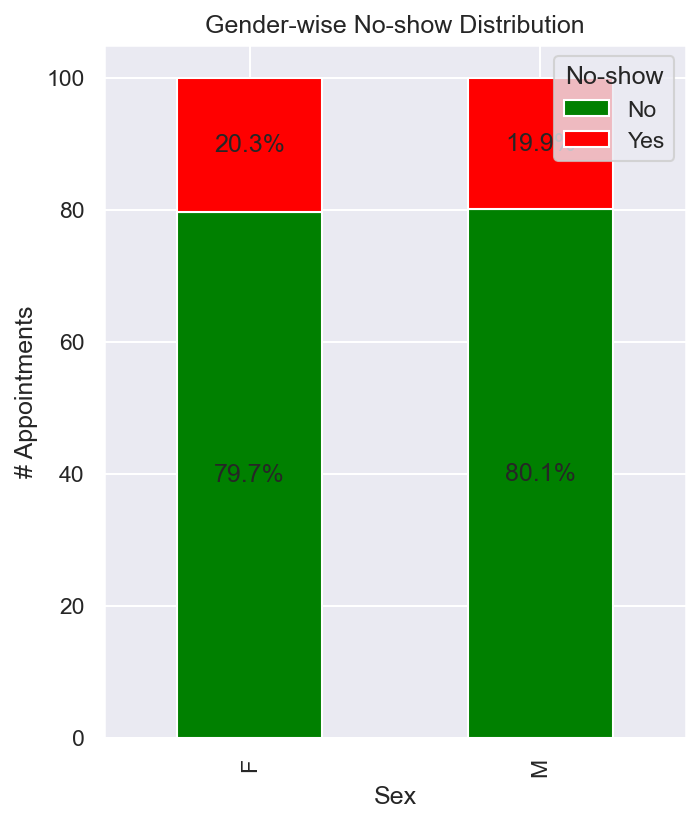

In [19]:
## Which gender misses more appointments?

# Group by 'gender' and 'no_show' and count occurrences
grouped_data = df.groupby(['Sex', 'No-show']).size().unstack()

# Calculate percentages
percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting a grouped bar chart
ax = percentages.plot(kind='bar', stacked=True, color=[green, red])

# Annotate bars with percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Gender-wise No-show Distribution')
plt.xlabel('Sex')
plt.ylabel('# Appointments')
plt.legend(title='No-show', loc='upper right')

plt.show()

There seems to be 1 in 5 appointments missed for both genders.

### 5. Data Cleaning and Preprocessing
- Change the no show to show to make it more intuitive.

### 6. Train-Test Split

### 7. Model Selection


### 8. Model Training


### 9. Model Evaluation

### 10. Model Interpretation


### 11. Fine-Tuning and Optimization